In [1]:
import sys
from pathlib import Path

exp_dir = str(Path("..").resolve())
if exp_dir not in sys.path:
    sys.path.insert(0, exp_dir)

In [11]:
from pathlib import Path

import numpy as np
import torch

# 사용자 모듈 임포트
from config import CONFIG
from xrr_model import XRR1DRegressor


class XRRInferenceEngine:
    def __init__(self, exp_dir=None):
        """
        추론 엔진 초기화: 설정 로드, 모델 로드, 통계 로드
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[Inference] Device: {self.device}")

        # 1. 경로 설정
        if exp_dir is None:
            exp_dir = Path(CONFIG["base_dir"]) / CONFIG["exp_name"]
        else:
            exp_dir = Path(exp_dir)

        self.stats_file = exp_dir / "stats.pt"
        self.checkpoint_file = exp_dir / "best.pt"

        # 2. Master Grid 설정 (학습과 동일해야 함)
        self.q_min = CONFIG["simulation"]["q_min"]
        self.q_max = CONFIG["simulation"]["q_max"]
        self.n_points = CONFIG["simulation"]["q_points"]
        # print(self.q_min, self.q_max, self.n_points)
        # 모델이 바라보는 고정된 q축 생성
        self.target_q = np.linspace(self.q_min, self.q_max, self.n_points).astype(np.float32)

        # 3. 정규화 통계 로드
        if not self.stats_file.exists():
            raise FileNotFoundError(f"통계 파일이 없습니다: {self.stats_file}")

        stats = torch.load(self.stats_file, map_location=self.device)
        self.param_mean = stats["param_mean"]
        self.param_std = stats["param_std"]

        # 4. 모델 로드
        self._load_model()

    def _load_model(self):
        """모델 생성 및 가중치 로드"""
        if not self.checkpoint_file.exists():
            raise FileNotFoundError(f"체크포인트가 없습니다: {self.checkpoint_file}")

        # 체크포인트에서 모델 설정 가져오기 (없으면 Config 사용)
        ckpt = torch.load(self.checkpoint_file, map_location=self.device)
        model_args = ckpt.get('config', {}).get('model_args', {
            'q_len': self.n_points,
            'input_channels': 2, # [중요] 2채널 고정
            'n_channels': CONFIG["model"]["n_channels"],
            'depth': CONFIG["model"]["depth"],
            'mlp_hidden': CONFIG["model"]["mlp_hidden"],
        })

        self.model = XRR1DRegressor(**model_args).to(self.device)
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval()
        print(f"[Inference] Model loaded from {self.checkpoint_file}")

    def preprocess(self, q_raw, R_raw):
        """
        Raw Data -> Model Input Tensor 변환
        (Dataset.__getitem__ 로직과 동일하게 구현)
        """
        # 1. Normalize R (Max Norm -> Log10)
        R_max = np.max(R_raw)
        R_norm = R_raw / (R_max + 1e-15)
        R_log = np.log10(np.maximum(R_norm, 1e-15))

        # 2. Interpolation (Master Grid로 내삽)
        # q_raw가 오름차순이어야 np.interp가 정확함
        if q_raw[0] > q_raw[-1]:
            q_raw = q_raw[::-1]
            R_log = R_log[::-1]

        R_interp = np.interp(self.target_q, q_raw, R_log, left=0.0, right=0.0)

        # 3. Masking
        q_valid_mask = (self.target_q >= np.min(q_raw)) & (self.target_q <= np.max(q_raw))

        # 4. Tensor 변환 & Stacking
        R_tensor = torch.from_numpy(R_interp.astype(np.float32))
        mask_tensor = torch.from_numpy(q_valid_mask.astype(np.float32))

        # Shape: (2, n_points)
        input_tensor = torch.stack([R_tensor, mask_tensor], dim=0)

        # Batch 차원 추가: (1, 2, n_points)
        return input_tensor.unsqueeze(0).to(self.device)

    def predict(self, q_raw, R_raw):
        """
        단일 데이터 추론 수행
        Returns: (thickness, roughness, sld) -> 실제 물리 단위
        """
        # 전처리
        x = self.preprocess(q_raw, R_raw)

        # 추론
        with torch.no_grad():
            # Output: (1, 3) -> Normalized Params
            y_pred_norm = self.model(x).squeeze(0)

        # 역정규화 (Denormalization)
        # Z-score 역변환: X = Z * Std + Mean
        y_pred = y_pred_norm * self.param_std + self.param_mean

        # Tensor -> Numpy / List 변환
        return y_pred.cpu().numpy()


a = XRRInferenceEngine()

[Inference] Device: cuda
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\mask\best.pt


[autoreload of reflecto.simulate.simul_genx failed: Traceback (most recent call last):
  File "d:\02_Projects\Dev\X-ray_AI\Reflecto\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\02_Projects\Dev\X-ray_AI\Reflecto\.venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
UnicodeDecodeError: 'cp949' codec can't decode byte 0xed in position 696: illegal multibyte sequence
]


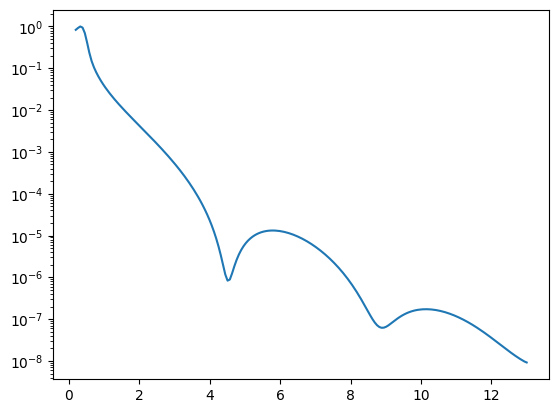

In [42]:
import matplotlib.pyplot as plt

from reflecto.simulate.simul_genx import ParamSet, params2refl, tth2q_wavelen

wavelen: float = 1.54
tth_min: float = 0.2   # degree
tth_max: float = 13
tth_n: int = 200
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q_wavelen(tths, wavelen)

param = ParamSet(20, 3, 2)
sim_refl = params2refl([param], qs)

refl = sim_refl
refl = refl / refl.max()
# refl = refl / refl[0]
plt.plot(tths, refl)
plt.yscale("log")

In [43]:
from reflecto.simulate.simul_genx import tth2q_wavelen
from reflecto.simulate.simul_genx import params2refl
engine = XRRInferenceEngine(exp_dir=r"D:\03_Resources\Data\XRR_AI\data\one_layer\mask")

# 2. 가상의 측정 데이터 (예시: qs와 true_refl이 있다고 가정)
# 실제 상황에서는 qs, true_refl = load_my_data()
print("\n--- Single Data Prediction ---")

# 테스트용 더미 데이터 생성 (사용자 데이터로 교체하세요)
test_q = qs
test_R = refl

# 3. 예측 실행
thickness_pred, roughness_pred, sld_pred = engine.predict(test_q, test_R)
param = ParamSet(thickness_pred, roughness_pred, sld_pred)

print("Predicted Parameters:")
print(f"  Thickness: {thickness_pred:.4f} Å")
print(f"  Roughness: {roughness_pred:.4f} Å")
print(f"  SLD:       {sld_pred:.4e} (10^-6 Å^-2)")

[Inference] Device: cuda
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\mask\best.pt

--- Single Data Prediction ---
Predicted Parameters:
  Thickness: 40.1999 Å
  Roughness: 2.1213 Å
  SLD:       2.2379e+00 (10^-6 Å^-2)


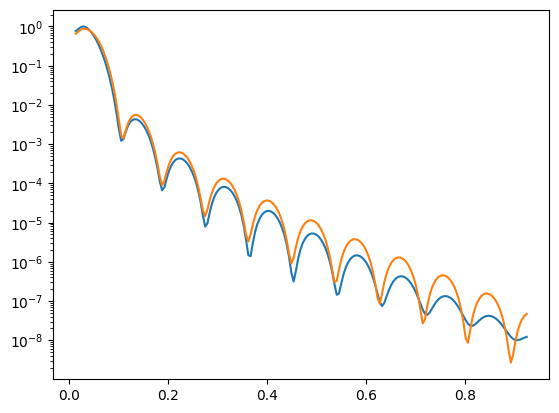

In [31]:
param = ParamSet(thickness_pred, roughness_pred, sld_pred)
sim_refl = params2refl([param], test_q)

plt.plot(test_q, refl)
plt.plot(test_q, sim_refl)
plt.yscale("log")

plt.show()

In [38]:
import numpy as np
from genx.data import DataList, DataSet
from genx.model import Model
from genx.parameters import Parameters

# 1) 측정 데이터 준비
qz = qs
R  = sim_refl
dR = np.maximum(R*0.3, 1e-8)  # 0 에러 방지 권장

ds = DataSet(name="XRR 1-layer")
ds.x_raw = test_q
ds.y_raw = R
ds.error_raw = dR
ds.run_command()

data = DataList([ds])

init_param = ParamSet(thickness_pred, roughness_pred, sld_pred)

script_text = rf"""
from genx.models.spec_nx import Sample, Stack, Layer, Instrument, Specular
from genx.models.spec_nx import Probe, Coords, ResType, FootType

initial_thickness = {init_param.thickness}
initial_roughness = {init_param.roughness}
initial_sld = {init_param.sld * 10e-6}  # Å^-2

SI_SLD = 2.07e-6  # Å^-2
initial_I0 = 1.0
class Vars:
    def __init__(self, d, sigma, sld, i0):
        self._d = float(d)
        self._sigma = float(sigma)
        self._sld = float(sld)
        self._i0 = float(i0)
    def set_thickness(self, v): self._d = float(v)
    def get_thickness(self):    return self._d
    def set_roughness(self, v): self._sigma = float(v)
    def get_roughness(self):    return self._sigma
    def set_sld(self, v): self._sld = float(v)
    def get_sld(self):    return self._sld
    def set_I0(self, v): self._i0 = float(v)
    def get_I0(self):    return self._i0

vars = Vars(initial_thickness, initial_roughness, initial_sld, initial_I0)

Amb  = Layer(d=0.0, dens=0.0, f=0.0)
Sub  = Layer(d = 0.0, f=SI_SLD*1e5, dens=1.0, sigma=3.0)  # ← 1e5
Film = Layer(d=vars.get_thickness(),
             sigma=vars.get_roughness(),
             f=vars.get_sld()*1e6,  # _sync와 동일하게 1e6을 곱해줌
             dens=1.0)
SURFACE_SIO2 = Layer(
    d=15.0,
    f=complex(14, 0.1),
    dens=0.05,
    sigma=2.0
)

sample = Sample(Stacks=[Stack(Layers=[SURFACE_SIO2, Film])], Ambient=Amb, Substrate=Sub)

inst = Instrument(
    probe=Probe.xray,
    wavelength=1.54,
    coords=Coords.q,
    I0=vars.get_I0(),
    Ibkg=1e-10,
    res=0.005,
    restype=ResType.fast_conv, # 분해능 컨볼루션
    footype=FootType.gauss
)

def _sync():
    Film.d     = vars.get_thickness()
    Film.sigma = vars.get_roughness()
    Film.f     = vars.get_sld()*1e5
    inst.I0    = vars.get_I0()

def Sim(data):
    _sync()
    return [Specular(di.x, sample, inst) for di in data]
"""
from genx import fom_funcs

# 3) 모델 생성 및 스크립트 설정
model = Model()
model.data = data
model.set_script(script_text)
model.compile_script()

# 1. 파라미터 등록 (I0 추가)
pars = Parameters()

# (기존 파라미터들 등록 - 일단 fit=False로 둠)
p_thick = pars.append("vars.set_thickness", model)
p_thick.value = init_param.thickness
p_thick.fit = False  # 일단 끔

p_rough = pars.append("vars.set_roughness", model)
p_rough.value = init_param.roughness
p_rough.fit = False  # 일단 끔

p_sld = pars.append("vars.set_sld", model)
p_sld.value = init_param.sld * 1e-5
p_sld.fit = False    # 일단 끔

# [핵심] I0 파라미터 등록 및 켜기
p_i0 = pars.append("vars.set_I0", model)
p_i0.value = 1.0       # 초기값
p_i0.min = 0.1         # 범위 설정
p_i0.max = 10.0
p_i0.fit = True        # 이것만 켬

model.parameters = pars

# ---------------------------------------------------------
# [단계 1] Linear Scale에서 I0만 피팅
# ---------------------------------------------------------
print("--- Step 1: Fitting I0 in Linear Scale ---")

# FOM 함수를 Linear(chi2 또는 abs_diff)로 변경 [cite: 369, 371]
# fom_funcs.chi2는 (sim - meas)^2 / err^2 의 합입니다.
# 로그를 취하지 않으므로 큰 값(전반사 영역)이 피팅을 지배하게 되어 I0 맞추기에 유리합니다.
model.set_fom_func(fom_funcs.diff)

# I0는 단순한 스케일링이므로 복잡한 dream 대신 'de'나 'amoeba'등 으로 빠르게 끝냅니다.
res_i0 = model.bumps_fit(method="de")
model.bumps_update_parameters(res_i0)

print(f"Fitted I0: {p_i0.value}")

# ---------------------------------------------------------
# [단계 2] Log Scale에서 전체 파라미터 피팅
# ---------------------------------------------------------
print("--- Step 2: Full Fitting in Log Scale ---")

# FOM 함수를 다시 Log로 복구 (반사율 피팅의 표준) [cite: 371]
model.set_fom_func(fom_funcs.log)

# 다른 파라미터들 피팅 켜기
p_thick.fit = True
p_rough.fit = True
p_sld.fit   = True
# I0도 미세 조정을 위해 켜두거나, 고정하고 싶으면 False로 변경
p_i0.fit    = False

# 본격적인 피팅 (DE 또는 DREAM)
res_final = model.bumps_fit(method="de", steps=1000, pop=20, tol=0.01)
model.bumps_update_parameters(res_final)

model.evaluate_sim_func()
print("Final Results:")
for par in model.parameters:
    print(f"  {par.name} = {par.value}")

--- Step 1: Fitting I0 in Linear Scale ---
Fitted I0: 1.0
--- Step 2: Full Fitting in Log Scale ---
Final Results:
   = 0.0
  vars.set_thickness = 70.66523154609462
  vars.set_roughness = 2.2436601825852356
  vars.set_sld = 2.3387182650008516e-05
  vars.set_I0 = 1.0


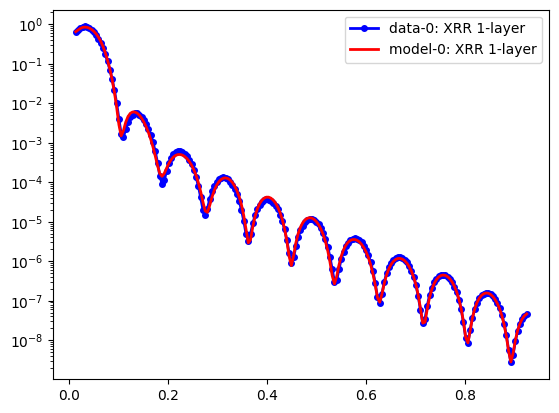

In [39]:
from genx.diffev import DiffEv
from genx.model_control import ModelController

controller = ModelController(DiffEv())
controller.set_model(model)
controller.StartFit()

fitted = controller.get_fitted_model()
fitted.simulate()
fitted.data.plot()
plt.show()

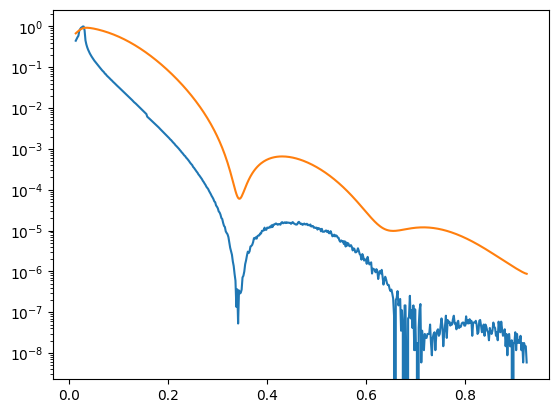

In [27]:
param = ParamSet(20, 3, sld_pred)
sim_refl = params2refl([param], test_q)

plt.plot(test_q, refl)
plt.plot(test_q, sim_refl)
plt.yscale("log")

plt.show()